# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [1]:
%%time

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import math
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

Wall time: 1min 13s


## 1.1 Reading Data

In [2]:
#using 50k rows due to memory constaint 
project_data = pd.read_csv('train_data.csv',nrows=50000)
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (50000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [5]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [6]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [7]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [8]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [9]:
#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [10]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [13]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [14]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['preprocessed_essays'] = preprocessed_essays

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [00:50<00:00, 999.82it/s]


In [17]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

#### Number of words in combined Essay

In [18]:
proj_essay_wrd_count = []

for word in project_data['preprocessed_essays']:
    proj_essay_wrd_count.append(len(word.split()))
project_data['proj_essay_wrd_count'] = proj_essay_wrd_count

project_data.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   
2                 Health_Sports    Health_Wellness TeamSports   

                                               essay  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                 preprocessed_essays  proj_essay_wrd_count  
0  my students english learners working english s...                   161  
1  our students arrive school eager learn they po...                   109  
2  true champions not always ones win guts by mia...                   202

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [19]:
# similarly you can preprocess the titles also
# printing some random essays.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year


In [22]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())
project_data['preprocessed_titles'] = preprocessed_titles

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 22983.71it/s]


In [23]:
project_data.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2  \
0  \"The limits of your language are the limits o...   
1  The projector we need for our school is very c...   
2  The students on the campus come to school know...   

                        ...                        project_essay_4  \
0                       ...                                    NaN   
1                       ...                                    NaN   
2                       ...                                    NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   
2  My students need shine guards, athletic socks,...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   
2                                            1                    0   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   
2                 Health_Sports    Health_Wellness TeamSports   

                                               essay  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                 preprocessed_essays proj_essay_wrd_count  \
0  my students english learners working english s...                  161   
1  our students arrive school eager learn they po...                  109   
2  true champions not always ones win guts by mia...                  202   

                               preprocessed_titles  
0        educational support english learners home  
1                 wanted projector hungry learners  
2  soccer equipment awesome middle school students  

[3 rows x 21 columns]

#### Number of words in project title


In [24]:
proj_title_wrd_count = []

for word in project_data['preprocessed_titles']:
    proj_title_wrd_count.append(len(word.split()))
project_data['proj_title_wrd_count'] = proj_title_wrd_count
project_data.head(3)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2          ...           \
0  \"The limits of your language are the limits o...          ...            
1  The projector we need for our school is very c...          ...            
2  The students on the campus come to school know...          ...            

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   
2  My students need shine guards, athletic socks,...   

  teacher_number_of_previously_posted_projects project_is_approved  \
0                                            0                   0   
1                                            7                   1   
2                                            1                   0   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   
2                 Health_Sports    Health_Wellness TeamSports   

                                               essay  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                 preprocessed_essays proj_essay_wrd_count  \
0  my students english learners working english s...                  161   
1  our students arrive school eager learn they po...                  109   
2  true champions not always ones win guts by mia...                  202   

                               preprocessed_titles  proj_title_wrd_count  
0        educational support english learners home                     5  
1                 wanted projector hungry learners                     4  
2  soccer equipment awesome middle school students                     6  

[3 rows x 22 columns]

In [25]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

neg = []
pos = []
neu = []
compound = []

sid = SentimentIntensityAnalyzer()

for for_sentiment  in tqdm(project_data['preprocessed_essays']):

    neg.append(sid.polarity_scores(for_sentiment)['neg']) #Negative Sentiment score
    pos.append(sid.polarity_scores(for_sentiment)['pos']) #Positive Sentiment score
    neu.append(sid.polarity_scores(for_sentiment)['neu']) #Neutral Sentiment score
    compound.append(sid.polarity_scores(for_sentiment)['compound']) #Compound Sentiment score

# Creating new features    
project_data['Essay_neg_ss']      = neg
project_data['Essay_pos_ss']      = pos
project_data['Essay_neu_ss']      = neu
project_data['Essay_compound_ss'] = compound

project_data.head(3)

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [10:28<00:00, 79.53it/s]


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                     project_essay_2        ...          \
0  \"The limits of your language are the limits o...        ...           
1  The projector we need for our school is very c...        ...           
2  The students on the campus come to school know...        ...           

            clean_subcategories  \
0                  ESL Literacy   
1  Civics_Government TeamSports   
2    Health_Wellness TeamSports   

                                               essay  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   

                                 preprocessed_essays  proj_essay_wrd_count  \
0  my students english learners working english s...                   161   
1  our students arrive school eager learn they po...                   109   
2  true champions not always ones win guts by mia...                   202   

                               preprocessed_titles proj_title_wrd_count  \
0        educational support english learners home                    5   
1                 wanted projector hungry learners                    4   
2  soccer equipment awesome middle school students                    6   

  Essay_neg_ss Essay_pos_ss Essay_neu_ss  Essay_compound_ss  
0        0.012        0.144        0.844             0.9694  
1        0.048        0.283        0.669             0.9856  
2        0.122        0.219        0.659             0.9816  

[3 rows x 26 columns]

## 1.4.1 Project_grade preprocessing

In [26]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(" ", "_")
project_data['project_grade_category'].value_counts()

Grades_PreK-2    20316
Grades_3-5       16968
Grades_6-8        7750
Grades_9-12       4966
Name: project_grade_category, dtype: int64

### Preprocessing teacher_prefix

In [27]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace(".","")
project_data['teacher_prefix'].value_counts()

Mrs        26140
Ms         17936
Mr          4859
Teacher     1061
Dr             2
Name: teacher_prefix, dtype: int64

## 1.5 Preparing data for models

In [28]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay',
       'preprocessed_essays', 'proj_essay_wrd_count', 'preprocessed_titles',
       'proj_title_wrd_count', 'Essay_neg_ss', 'Essay_pos_ss', 'Essay_neu_ss',
       'Essay_compound_ss'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### Split data into train,test and Cross validate


In [29]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(project_data, project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'])

### 1.5.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

### Response Coding - Clean_Categories


In [30]:
#splitting data based on positive and negative
X_train_pos = X_train.loc[X_train['project_is_approved'] == 1]
X_train_neg = X_train.loc[X_train['project_is_approved'] == 0]

#positive class
clean_category_pos = {}

for a in X_train_pos['clean_categories'] :
    for b in a.split():
        if b not in clean_category_pos :
            clean_category_pos[b] = 1
        else :
            clean_category_pos[b] += 1
# negtive class            
clean_category_neg = {}

for a in X_train_neg['clean_categories'] :
    for b in a.split():
        if b not in clean_category_neg :
            clean_category_neg[b] = 1
        else :
            clean_category_neg[b] += 1
            
#total count 
clean_category_total = {}

for a in X_train['clean_categories'] :
    for b in a.split():
        if b not in clean_category_total :
            clean_category_total[b] = 1
        else :
            clean_category_total[b] += 1
            
#positive probbility 

pos_prob_category = {}

for x in clean_category_total.keys():
    pos_prob_category[x] = (clean_category_pos[x])/float(clean_category_total[x])
    
    
#negative probability

neg_prob_category = {}

for y in clean_category_total.keys():
    neg_prob_category[y] = (clean_category_neg[y])/float(clean_category_total[y])
    
#Probabilities to train data

cat_0_train = []
cat_1_train = []

for a in X_train["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_0_train.append(neg_prob_category[a])
        cat_1_train.append(pos_prob_category[a])
    else :
        c = neg_prob_category[b[0]]
        d = neg_prob_category[b[1]]
        e = pos_prob_category[b[0]]
        f = pos_prob_category[b[1]]
        
        cat_0_train.append(c*d)
        cat_1_train.append(e*f)
#Probabilites to test data 

cat_0_test = []
cat_1_test = []

for a in X_test["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_0_test.append(neg_prob_category[a])
        cat_1_test.append(pos_prob_category[a])
    else :
        c = neg_prob_category[b[0]]
        d = neg_prob_category[b[1]]
        e = pos_prob_category[b[0]]
        f = pos_prob_category[b[1]]
        
        cat_0_test.append(c*d)
        cat_1_test.append(e*f)
        
X_train["cat_0"] = cat_0_train
X_train["cat_1"] = cat_1_train
X_test["cat_0"] = cat_0_test
X_test["cat_1"] = cat_1_test


#normalize to 0 

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

normalizer.fit(X_train["cat_0"].values.reshape(-1,1))

cat_0_train = normalizer.transform(X_train["cat_0"].values.reshape(-1,1))
cat_0_test = normalizer.transform(X_test["cat_0"].values.reshape(-1,1))
print("="*100)
print("After vectorizations for normalize 0")
print(cat_0_train.shape, Y_train.shape)
print(cat_0_test.shape, Y_test.shape)
print("="*100)

#normalize to 1

normalizer.fit(X_train["cat_1"].values.reshape(-1,1))

cat_1_train = normalizer.transform(X_train["cat_1"].values.reshape(-1,1))
cat_1_test = normalizer.transform(X_test["cat_1"].values.reshape(-1,1))

print("="*100)
print("After vectorizations for normalize 1")
print(cat_1_train.shape, Y_train.shape)
print(cat_1_test.shape, Y_test.shape)
print("="*100)

After vectorizations for normalize 0
(33500, 1) (33500,)
(16500, 1) (16500,)
After vectorizations for normalize 1
(33500, 1) (33500,)
(16500, 1) (16500,)


### Response Coding - Clean_Sub-Categories

In [31]:
#splitting data based on positive and negative

#positive class
clean_subcategory_pos = {}

for a in X_train_pos['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_pos :
            clean_subcategory_pos[b] = 1
        else :
            clean_subcategory_pos[b] += 1
# negtive class            
clean_subcategory_neg = {}

for a in X_train_neg['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_neg :
            clean_subcategory_neg[b] = 1
        else :
            clean_subcategory_neg[b] += 1
            
#total count 
clean_subcategory_total = {}

for a in X_train['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_total :
            clean_subcategory_total[b] = 1
        else :
            clean_subcategory_total[b] += 1
#positive probbility 

pos_prob_subcategory = {}

for x in clean_subcategory_total.keys():
    pos_prob_subcategory[x] = (clean_subcategory_pos[x])/float(clean_subcategory_total[x])
    
    
#negative probability

neg_prob_subcategory = {}

for x in clean_subcategory_total.keys():
    neg_prob_subcategory[x] = (clean_subcategory_neg[x])/float(clean_subcategory_total[x])
#Probabilities to train data

subcat_0_train = []
subcat_1_train = []

for a in X_train["clean_subcategories"] :
    b = a.split()
    if len(b) == 1 :
        subcat_0_train.append(neg_prob_subcategory[a])
        subcat_1_train.append(pos_prob_subcategory[a])
    else :
        c = neg_prob_subcategory[b[0]]
        d = neg_prob_subcategory[b[1]]
        e = pos_prob_subcategory[b[0]]
        f = pos_prob_subcategory[b[1]]
        
        subcat_0_train.append(c*d)
        subcat_1_train.append(e*f)
#Probabilites to test data 

subcat_0_test = []
subcat_1_test = []

for a in X_test["clean_subcategories"] :
    b = a.split()
    if len(b) == 1 :
        subcat_0_test.append(neg_prob_subcategory[a])
        subcat_1_test.append(pos_prob_subcategory[a])
    else :
        c = neg_prob_subcategory[b[0]]
        d = neg_prob_subcategory[b[1]]
        e = pos_prob_subcategory[b[0]]
        f = pos_prob_subcategory[b[1]]
        
        subcat_0_test.append(c*d)
        subcat_1_test.append(e*f)
        
X_train["subcat_0"] = subcat_0_train
X_train["subcat_1"] = subcat_1_train
X_test["subcat_0"] = subcat_0_test
X_test["subcat_1"] = subcat_1_test


#normalize to 0 

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

normalizer.fit(X_train["subcat_0"].values.reshape(-1,1))

subcat_0_train = normalizer.transform(X_train["subcat_0"].values.reshape(-1,1))
subcat_0_test = normalizer.transform(X_test["subcat_0"].values.reshape(-1,1))
print("="*100)
print("After vectorizations for normalize 0")
print(subcat_0_train.shape, Y_train.shape)
print(subcat_0_test.shape, Y_test.shape)
print("="*100)
print("="*100)

#normalize to 1

normalizer.fit(X_train["subcat_1"].values.reshape(-1,1))

subcat_1_train = normalizer.transform(X_train["subcat_1"].values.reshape(-1,1))
subcat_1_test = normalizer.transform(X_test["subcat_1"].values.reshape(-1,1))

print("="*100)
print("After vectorizations for normalize 1")
print(subcat_1_train.shape, Y_train.shape)
print(subcat_1_test.shape, Y_test.shape)
print("="*100)

After vectorizations for normalize 0
(33500, 1) (33500,)
(16500, 1) (16500,)
After vectorizations for normalize 1
(33500, 1) (33500,)
(16500, 1) (16500,)


In [32]:
# you can do the similar thing with state, teacher_prefix and project_grade_category also

### Response Coding - School_States

In [33]:
#splitting data based on positive and negative

#positive class
school_state_pos = {}

for a in X_train_pos['school_state'] :
    if a not in school_state_pos :
        school_state_pos[a] = 1
    else :
        school_state_pos[a] += 1
# negtive class            
school_state_neg = {}

for a in X_train_neg['school_state'] :
    if a not in school_state_neg :
        school_state_neg[a] = 1
    else :
        school_state_neg[a] += 1
            
#total count 
school_state_total = {}

for a in X_train['school_state'] :
    if a not in school_state_total :
        school_state_total[a] = 1
    else :
        school_state_total[a] += 1

#positive probbility 

pos_prob_state = {}

for x in school_state_total.keys():
    pos_prob_state[x] = (school_state_pos[x])/float(school_state_total[x])
    
    
#negative probability

neg_prob_state = {}

for y in school_state_total.keys():
    neg_prob_state[y] = (school_state_neg[y])/float(school_state_total[y])
#Probabilities to train data

state_0_train = []
state_1_train = []

for a in X_train["school_state"] :
    state_0_train.append(neg_prob_state[a])
    state_1_train.append(pos_prob_state[a])
#Probabilites to test data 

state_0_test = []
state_1_test = []

for a in X_test["school_state"] :
    state_0_test.append(neg_prob_state[a])
    state_1_test.append(pos_prob_state[a])
        
X_train["state_0"] =state_0_train
X_train["state_1"] = state_1_train
X_test["state_0"] =state_0_test
X_test["state_1"] =state_1_test


#normalize to 0 

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

normalizer.fit(X_train["state_0"].values.reshape(-1,1))
state_0_train = normalizer.transform(X_train["state_0"].values.reshape(-1,1))
state_0_test = normalizer.transform(X_test["state_0"].values.reshape(-1,1))
print("="*100)
print("After vectorizations for normalize 0")
print(state_0_train.shape, Y_train.shape)
print(state_0_test.shape, Y_test.shape)
print("="*100)
print("="*100)

#normalize to 1

normalizer.fit(X_train["subcat_1"].values.reshape(-1,1))

state_1_train = normalizer.transform(X_train["state_1"].values.reshape(-1,1))
state_1_test = normalizer.transform(X_test["state_1"].values.reshape(-1,1))

print("="*100)
print("After vectorizations for normalize 1")
print(state_1_train.shape, Y_train.shape)
print(state_1_test.shape, Y_test.shape)
print("="*100)

After vectorizations for normalize 0
(33500, 1) (33500,)
(16500, 1) (16500,)
After vectorizations for normalize 1
(33500, 1) (33500,)
(16500, 1) (16500,)


### Response coding - Project_Grade_Category

In [34]:
#splitting data based on positive and negative

#positive class
project_grade_pos = {}

for a in X_train_pos['project_grade_category'] :
    if a not in project_grade_pos :
        project_grade_pos[a] = 1
    else :
        project_grade_pos[a] += 1
# negtive class            
project_grade_neg = {}

for a in X_train_neg['project_grade_category'] :
    if a not in project_grade_neg :
        project_grade_neg[a] = 1
    else :
        project_grade_neg[a] += 1
            
#total count 
project_grade_total = {}

for a in X_train['project_grade_category'] :
    if a not in project_grade_total :
        project_grade_total[a] = 1
    else :
        project_grade_total[a] += 1

#positive probbility 

pos_prob_grade_cat = {}

for x in project_grade_total.keys():
    pos_prob_grade_cat[x] = (project_grade_pos[x])/float(project_grade_total[x])
    
    
#negative probability

neg_prob_grade_cat = {}

for y in project_grade_total.keys():
    neg_prob_grade_cat[y] = (project_grade_neg[y])/float(project_grade_total[y])
#Probabilities to train data

proj_grade_0_train = []
proj_grade_1_train = []

for a in X_train["project_grade_category"] :
    proj_grade_0_train.append(neg_prob_grade_cat[a])
    proj_grade_1_train.append(pos_prob_grade_cat[a])
#Probabilites to test data 

proj_grade_0_test = []
proj_grade_1_test = []

for a in X_test["project_grade_category"] :
    proj_grade_0_test.append(neg_prob_grade_cat[a])
    proj_grade_1_test.append(pos_prob_grade_cat[a])
        
X_train["proj_grade_0"] = proj_grade_0_train
X_train["proj_grade_1"] = proj_grade_1_train
X_test["proj_grade_0"] = proj_grade_0_test
X_test["proj_grade_1"] = proj_grade_1_test


#normalize to 0 

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

normalizer.fit(X_train["proj_grade_0"].values.reshape(-1,1))

proj_grade_0_train = normalizer.transform(X_train["proj_grade_0"].values.reshape(-1,1))
proj_grade_0_test = normalizer.transform(X_test["proj_grade_0"].values.reshape(-1,1))


print("="*100)
print("After vectorizations for normalize 0")
print(proj_grade_0_train.shape, Y_train.shape)
print(proj_grade_0_test.shape, Y_test.shape)
print("="*100)
print("="*100)

#normalize to 1

normalizer.fit(X_train["proj_grade_1"].values.reshape(-1,1))

proj_grade_1_train = normalizer.transform(X_train["proj_grade_1"].values.reshape(-1,1))
proj_grade_1_test = normalizer.transform(X_test["proj_grade_1"].values.reshape(-1,1))

print("="*100)
print("After vectorizations for normalize 1")
print(proj_grade_1_train.shape, Y_train.shape)
print(proj_grade_1_test.shape, Y_test.shape)
print("="*100)

After vectorizations for normalize 0
(33500, 1) (33500,)
(16500, 1) (16500,)
After vectorizations for normalize 1
(33500, 1) (33500,)
(16500, 1) (16500,)


### Response coding - Teacher_Prefix

In [35]:
#splitting data based on positive and negative

#positive class
teacher_prefix_pos = {}

for a in X_train_pos['teacher_prefix'] :
    if a not in teacher_prefix_pos :
        teacher_prefix_pos[a] = 1
    else :
        teacher_prefix_pos[a] += 1
# negtive class    


teacher_prefix_neg = {}
teacher_prefix_neg[np.nan] =0

for a in X_train['teacher_prefix'] :
    if a not in teacher_prefix_neg :
        teacher_prefix_neg[a] = 1
    else :
        teacher_prefix_neg[a] += 1
            
#total count 
teacher_prefix_total = {}

for a in X_train['teacher_prefix'] :
    if a not in teacher_prefix_total :
        teacher_prefix_total[a] = 1
    else :
        teacher_prefix_total[a] += 1

#positive probbility 

pos_prob_teacher_prefix = {}

for x in teacher_prefix_total.keys():
    pos_prob_teacher_prefix[x] = (teacher_prefix_pos[x])/float(teacher_prefix_total[x])
    
    
#negative probability

neg_prob_teacher_prefix = {}

for y in teacher_prefix_total.keys():
    neg_prob_teacher_prefix[y] = (teacher_prefix_neg[y])/float(teacher_prefix_total[y])
#Probabilities to train data

teacher_prefix_0_train = []
teacher_prefix_1_train = []

for a in X_train["teacher_prefix"] :
    teacher_prefix_0_train.append(neg_prob_teacher_prefix[a])
    teacher_prefix_1_train.append(pos_prob_teacher_prefix[a])
#Probabilites to test data 

teacher_prefix_0_test = []
teacher_prefix_1_test = []

for a in X_test["teacher_prefix"] :
    teacher_prefix_0_test.append(neg_prob_teacher_prefix[a])
    teacher_prefix_1_test.append(pos_prob_teacher_prefix[a])
        
X_train["teacher_prefix_0"] = teacher_prefix_0_train
X_train["teacher_prefix_1"] = teacher_prefix_1_train
X_test["teacher_prefix_0"] = teacher_prefix_0_test
X_test["teacher_prefix_1"] = teacher_prefix_1_test


#normalize to 0 

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

normalizer.fit(X_train["teacher_prefix_0"].values.reshape(-1,1))

teacher_prefix_0_train = normalizer.transform(X_train["teacher_prefix_0"].values.reshape(-1,1))
teacher_prefix_0_test = normalizer.transform(X_test["teacher_prefix_0"].values.reshape(-1,1))



print("="*100)
print("After vectorizations for normalize 0")
print(teacher_prefix_0_train.shape, Y_train.shape)
print(teacher_prefix_0_test.shape, Y_test.shape)
print("="*100)
print("="*100)

#normalize to 1

normalizer.fit(X_train["teacher_prefix_1"].values.reshape(-1,1))

teacher_prefix_1_train = normalizer.transform(X_train["teacher_prefix_1"].values.reshape(-1,1))
teacher_prefix_1_test = normalizer.transform(X_test["teacher_prefix_1"].values.reshape(-1,1))


print("="*100)
print("After vectorizations for normalize 1")
print(teacher_prefix_1_train.shape, Y_train.shape)
print(teacher_prefix_1_test.shape, Y_test.shape)
print("="*100)

After vectorizations for normalize 0
(33500, 1) (33500,)
(16500, 1) (16500,)
After vectorizations for normalize 1
(33500, 1) (33500,)
(16500, 1) (16500,)


### 1.5.2 Vectorizing Text data

#### 1.5.2.1 Bag of words

#### BOW of eassys - Train/Test Data

In [36]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer_essay_bow = CountVectorizer(ngram_range=(2, 2),min_df=10,max_features=5000)
vectorizer_essay_bow.fit(X_train['preprocessed_essays'])

# BOW for essays Train Data
essay_bow_train = vectorizer_essay_bow.fit_transform(X_train['preprocessed_essays'])
print("Shape of matrix for TRAIN data ",essay_bow_train.shape)

# BOW for essays Test Data
essay_bow_test = vectorizer_essay_bow.transform(X_test['preprocessed_essays'])
print("Shape of matrix for TEST data",essay_bow_test.shape)


Shape of matrix for TRAIN data  (33500, 5000)
Shape of matrix for TEST data (16500, 5000)


#### BOW of Project Titles - Train/Test Data

In [37]:
vectorizer_title_bow = CountVectorizer(ngram_range=(2, 2),min_df=10,max_features=5000)
vectorizer_title_bow.fit(X_train['preprocessed_titles'])

# BOW for title Train Data
title_bow_train = vectorizer_title_bow.fit_transform(X_train['preprocessed_titles'])
print("Shape of matrix for TRAIN data ",title_bow_train.shape)

# BOW for title Test Data
title_bow_test = vectorizer_title_bow.transform(X_test['preprocessed_titles'])
print("Shape of matrix for TEST data",title_bow_test.shape)



Shape of matrix for TRAIN data  (33500, 1058)
Shape of matrix for TEST data (16500, 1058)


#### 1.5.2.2 TFIDF vectorizer for essay

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_essay_tfidf = TfidfVectorizer(ngram_range=(2, 2),min_df=10,max_features=5000)
vectorizer_essay_tfidf.fit(X_train['preprocessed_essays'])

#tidf Train Data
essay_tfidf_train = vectorizer_essay_tfidf.fit_transform(X_train['preprocessed_essays'])
print("Shape of matrix for TRAIN data",essay_tfidf_train.shape)

#tidf Test Data
essay_tfidf_test = vectorizer_essay_tfidf.transform(X_test['preprocessed_essays'])
print("Shape of matrix for TEST data",essay_tfidf_test.shape)



Shape of matrix for TRAIN data (33500, 5000)
Shape of matrix for TEST data (16500, 5000)


#### TFIDF vectorizer for Title

In [39]:
vectorizer_title_tfidf = TfidfVectorizer(ngram_range=(2, 2),min_df=10,max_features=5000)
vectorizer_title_tfidf.fit(X_train['preprocessed_titles'])

#tidf Train Data
title_tfidf_train = vectorizer_title_tfidf.fit_transform(X_train['preprocessed_titles'])
print("Shape of matrix for TRAIN data",title_tfidf_train.shape)

#tidf Test Data
title_tfidf_test = vectorizer_title_tfidf.transform(X_test['preprocessed_titles'])
print("Shape of matrix for TEST data",title_tfidf_test.shape)



Shape of matrix for TRAIN data (33500, 1058)
Shape of matrix for TEST data (16500, 1058)


#### 1.5.2.3 Using Pretrained Models: Avg W2V

In [40]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [41]:
# average Word2Vec Function
# compute average word2vec for each review.
# the avg-w2v for each sentence/review is stored in this list
def avg_w2v_vectors_func(sentance):
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    return vector

#### Train/Test - Avg-W2V for essay

In [42]:
essay_avg_w2v_train = []
essay_avg_w2v_test  = []
essay_avg_w2v_cv    = []

for sentence in tqdm(X_train['preprocessed_essays']):
    essay_avg_w2v_train.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Train data
    
# Avg-w2v for Train data    
print("len(essay_avg_w2v_train):",len(essay_avg_w2v_train))
print("len(essay_avg_w2v_train[0])",len(essay_avg_w2v_train[0]))

for sentence in tqdm(X_test['preprocessed_essays']):
    essay_avg_w2v_test.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Test data

# Avg-w2v for Test data
print("len(essay_avg_w2v_test):",len(essay_avg_w2v_test))
print("len(essay_avg_w2v_test[0])",len(essay_avg_w2v_test[0]))




100%|██████████████████████████████████████████████████████████████████████████| 33500/33500 [00:15<00:00, 2118.64it/s]


len(essay_avg_w2v_train): 33500
len(essay_avg_w2v_train[0]) 300


100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:07<00:00, 2156.84it/s]


len(essay_avg_w2v_test): 16500
len(essay_avg_w2v_test[0]) 300


In [43]:
title_avg_w2v_train = []
title_avg_w2v_test  = []

for sentence in tqdm(X_train['preprocessed_titles']):
    title_avg_w2v_train.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Train data
    
# Avg-w2v for Train data    
print("len(title_avg_w2v_train):",len(title_avg_w2v_train))
print("len(title_avg_w2v_train[0])",len(title_avg_w2v_train[0]))

for sentence in tqdm(X_test['preprocessed_titles']):
    title_avg_w2v_test.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Test data

# Avg-w2v for Test data
print("len(title_avg_w2v_test):",len(title_avg_w2v_test))
print("len(title_avg_w2v_test[0])",len(title_avg_w2v_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:00<00:00, 37396.92it/s]


len(title_avg_w2v_train): 33500
len(title_avg_w2v_train[0]) 300


100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 35878.66it/s]


len(title_avg_w2v_test): 16500
len(title_avg_w2v_test[0]) 300


#### 1.5.2.3 Using Pretrained Models: TFIDF weighted W2V

In [44]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [45]:
# Compute  TFIDF weighted W2V for each sentence of the review.

def tf_idf_weight_func(sentence): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    return vector

#### Train/Test Data - TFIDF weighted W2V for essay

In [46]:
essay_tfidf_w2v_train = []
essay_tfidf_w2v_test  = []

for sentence in tqdm(X_train['preprocessed_essays']):
    essay_tfidf_w2v_train.append(tf_idf_weight_func(sentance)) #  TFIDF weighted W2V for Train data
print("len(essay_tfidf_w2v_train)",len(essay_tfidf_w2v_train))
print("len(essay_tfidf_w2v_train[0])",len(essay_tfidf_w2v_train[0]))

for sentence in tqdm(X_test['preprocessed_essays']):
    essay_tfidf_w2v_test.append(tf_idf_weight_func(sentance)) #  TFIDF weighted W2V for Test data
print("len(essay_tfidf_w2v_test)",len(essay_tfidf_w2v_test))
print("len(essay_tfidf_w2v_test[0])",len(essay_tfidf_w2v_test[0]))



100%|████████████████████████████████████████████████████████████████████████| 33500/33500 [00:00<00:00, 146966.45it/s]


len(essay_tfidf_w2v_train) 33500
len(essay_tfidf_w2v_train[0]) 300


100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 98237.58it/s]


len(essay_tfidf_w2v_test) 16500
len(essay_tfidf_w2v_test[0]) 300


#### Train/Test Data - Avg-W2V for essay


In [47]:
title_avg_w2v_train = []
title_avg_w2v_test  = []
title_avg_w2v_cv    = []

for sentence in tqdm(X_train['preprocessed_titles']):
    title_avg_w2v_train.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Train data
    
# Avg-w2v for Train data    
print("len(title_avg_w2v_train):",len(title_avg_w2v_train))
print("len(title_avg_w2v_train[0])",len(title_avg_w2v_train[0]))

for sentence in tqdm(X_test['preprocessed_titles']):
    title_avg_w2v_test.append(avg_w2v_vectors_func(sentance)) # Avg-w2v for Test data

# Avg-w2v for Test data
print("len(title_avg_w2v_test):",len(title_avg_w2v_test))
print("len(title_avg_w2v_test[0])",len(title_avg_w2v_test[0]))




100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:00<00:00, 35495.46it/s]


len(title_avg_w2v_train): 33500
len(title_avg_w2v_train[0]) 300


100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 34672.47it/s]


len(title_avg_w2v_test): 16500
len(title_avg_w2v_test[0]) 300


#### Train/Test Data - TFIDF weighted W2V for Project Titles

In [48]:
title_tfidf_w2v_train  = []
title_tfidf_w2v_test  = []
title_tfidf_w2v_cv    = []

for sentence in tqdm(X_train['preprocessed_titles']):
    title_tfidf_w2v_train.append(tf_idf_weight_func(sentance)) #  TFIDF weighted W2V for Train data
print("len(title_tfidf_w2v_train)",len(title_tfidf_w2v_train))
print("len(title_tfidf_w2v_train[0])",len(title_tfidf_w2v_train[0]))

for sentence in tqdm(X_test['preprocessed_titles']):
    title_tfidf_w2v_test.append(tf_idf_weight_func(sentance)) #  TFIDF weighted W2V for Test data
print("len(title_tfidf_w2v_test)",len(title_tfidf_w2v_test))
print("len(title_tfidf_w2v_test[0])",len(title_tfidf_w2v_test[0]))



100%|████████████████████████████████████████████████████████████████████████| 33500/33500 [00:00<00:00, 121407.11it/s]


len(title_tfidf_w2v_train) 33500
len(title_tfidf_w2v_train[0]) 300


100%|████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 117886.77it/s]


len(title_tfidf_w2v_test) 16500
len(title_tfidf_w2v_test[0]) 300


### 1.5.3 Vectorizing Numerical features

In [49]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
X_train = pd.merge(X_train, price_data, on='id', how='left')
X_test = pd.merge(X_test, price_data, on='id', how='left')


In [50]:
from sklearn.preprocessing import Normalizer



normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(-1,1))

price_data_train = normalizer.fit_transform(X_train['price'].values.reshape(-1,1))

price_data_test = normalizer.transform(X_test['price'].values.reshape(-1,1))


print("After vectorizations")
print("="*100)
print(price_data_train.shape, Y_train.shape)
print(price_data_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


#### Vectorizing - Quantity Feature

In [51]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

print("="*100)
normalizer.fit(X_train['quantity'].values.reshape(-1,1))

quant_train = normalizer.fit_transform(X_train['quantity'].values.reshape(-1,1))
quant_test = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(quant_train.shape, Y_train.shape)
print(quant_test.shape, Y_test.shape)
print("="*100)

(33500, 38) (33500,)
(16500, 38) (16500,)
After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


####  Vectorizing - teacher_number_of_previously_posted_projects 

In [52]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

print("="*100)
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

prev_no_projects_train = normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_no_projects_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(prev_no_projects_train.shape, Y_train.shape)
print(prev_no_projects_test.shape, Y_test.shape)
print("="*100)

(33500, 38) (33500,)
(16500, 38) (16500,)
After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


####  Vectorizing - Word count title

In [53]:
normalizer = Normalizer()

normalizer.fit(X_train['proj_title_wrd_count'].values.reshape(-1,1))

title_cnt_train = normalizer.fit_transform(X_train['proj_title_wrd_count'].values.reshape(-1,1))
title_cnt_test = normalizer.transform(X_test['proj_title_wrd_count'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(title_cnt_train.shape, Y_train.shape)
print(title_cnt_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


####  Vectorizing - Essay count title

In [54]:
normalizer = Normalizer()

normalizer.fit(X_train['proj_essay_wrd_count'].values.reshape(-1,1))

essay_cnt_train = normalizer.fit_transform(X_train['proj_essay_wrd_count'].values.reshape(-1,1))
essay_cnt_test = normalizer.transform(X_test['proj_essay_wrd_count'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(title_cnt_train.shape, Y_train.shape)
print(title_cnt_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


####  Vectorizing - Sentiment Score negative

In [55]:
normalizer = Normalizer()

normalizer.fit(X_train['Essay_neg_ss'].values.reshape(-1,1))

essay_neg_train = normalizer.fit_transform(X_train['Essay_neg_ss'].values.reshape(-1,1))
essay_neg_test = normalizer.transform(X_test['Essay_neg_ss'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(essay_neg_train.shape, Y_train.shape)
print(essay_neg_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


####  Vectorizing - Sentiment Score positive

In [56]:
normalizer = Normalizer()

normalizer.fit(X_train['Essay_pos_ss'].values.reshape(-1,1))

essay_pos_train = normalizer.fit_transform(X_train['Essay_pos_ss'].values.reshape(-1,1))
essay_pos_test = normalizer.transform(X_test['Essay_pos_ss'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(essay_pos_train.shape, Y_train.shape)
print(essay_pos_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


####  Vectorizing - Sentiment Score neutral

In [57]:
normalizer = Normalizer()

normalizer.fit(X_train['Essay_neu_ss'].values.reshape(-1,1))

essay_neu_train = normalizer.fit_transform(X_train['Essay_neu_ss'].values.reshape(-1,1))
essay_neu_test = normalizer.transform(X_test['Essay_neu_ss'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(essay_neu_train.shape, Y_train.shape)
print(essay_neu_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


####  Vectorizing - Sentiment Score compound

In [58]:
normalizer = Normalizer()

normalizer.fit(X_train['Essay_compound_ss'].values.reshape(-1,1))

essay_compound_train = normalizer.fit_transform(X_train['Essay_compound_ss'].values.reshape(-1,1))
essay_compund_test = normalizer.transform(X_test['Essay_compound_ss'].values.reshape(-1,1))

print("="*100)
print("After vectorizations")
print(essay_compound_train.shape, Y_train.shape)
print(essay_compund_test.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


# Assignment 9: RF and GBDT

#### Response Coding: Example

<img src='response.JPG' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply both Random Forrest and GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters preferably n_estimators, max_depth)</strong>
        <ul>
          <li> Consider the following range for hyperparameters <b>n_estimators</b> = [10, 50, 100, 150, 200, 300, 500, 1000], 
            <b>max_depth</b> = [2, 3, 4, 5, 6, 7, 8, 9, 10] </li>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You can choose either of the plotting techniques: 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
            </ul>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h1>2. Random forest </h1>

## <font color='RED'> SET 1</font>

###   Applying Random forest on <font color='red'> BOW</font>

In [71]:
from scipy.sparse import hstack


X_train_merge = hstack((cat_0_train, cat_1_train, subcat_0_train, subcat_1_train, state_0_train, state_1_train, proj_grade_0_train, proj_grade_1_train, teacher_prefix_0_train, teacher_prefix_1_train, price_data_train, quant_train, prev_no_projects_train,title_cnt_train, essay_cnt_train, essay_pos_train, essay_neg_train, essay_neu_train, essay_compound_train, title_bow_train, essay_bow_train)).tocsr()
X_test_merge = hstack((cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, state_0_test, state_1_test, proj_grade_0_test, proj_grade_1_test, teacher_prefix_0_test, teacher_prefix_1_test, price_data_test, quant_test, prev_no_projects_test,title_cnt_test,essay_cnt_test, essay_pos_test, essay_neg_test, essay_neu_test, essay_compund_test, title_bow_test, essay_bow_test)).tocsr()

#### Best hyper prameter using the ROC/AUC higest value and K-fold cross validation.


In [57]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

parameters = {'n_estimators':[1, 5, 10, 50, 100, 500], 'max_depth': [5, 10, 100, 500]}


clf = GridSearchCV(rf, parameters, cv= 10 , scoring='roc_auc')

clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']


### Heatmap for the hyperparameters 


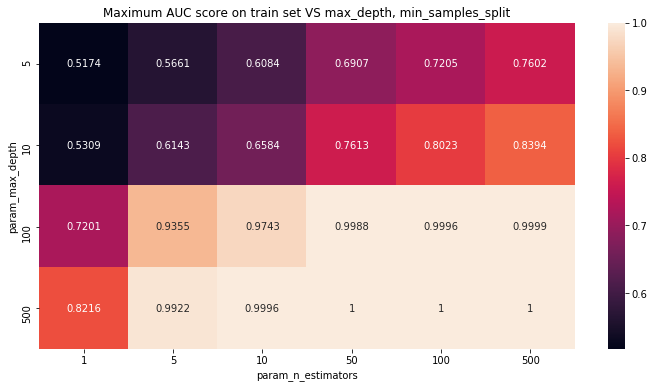

In [77]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

rf_gridsearch = pd.DataFrame(clf.cv_results_)

#Maximum AUC score on train set VS max_depth, min_samples_split
max_scores = rf_gridsearch.groupby(['param_max_depth',
                                    'param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.rcParams["figure.figsize"] = (12, 6)

title = 'Maximum AUC score on train set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

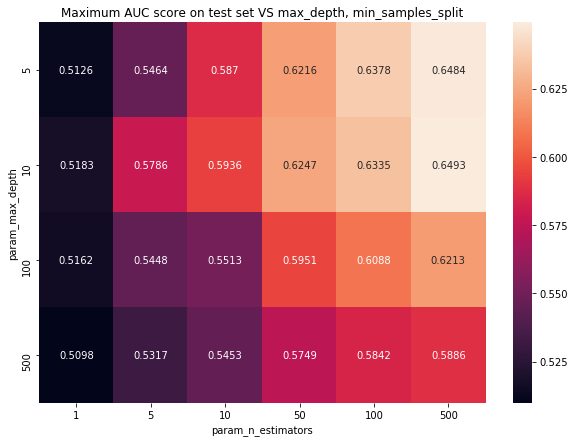

In [78]:
#Maximum AUC score on test set VS max_depth, min_samples_split

plt.rcParams["figure.figsize"] = (10, 7)


title = 'Maximum AUC score on test set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

### Best Train Model using best Hyper parameter


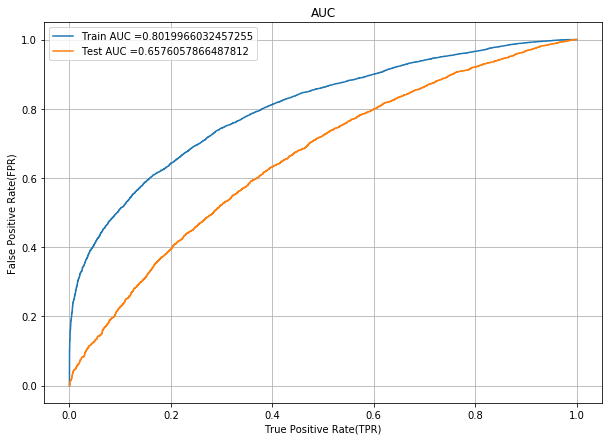

In [79]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 10, n_estimators= 500,class_weight='balanced')

clf = rf.fit(X_train_merge, Y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = rf.predict_proba(X_train_merge)[:,1]    
y_test_pred = rf.predict_proba(X_test_merge)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

### Confusion Matrix

In [58]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [81]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.5232571316049548 for threshold 0.498
[[ 3676  1492]
 [ 7490 20842]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.38054730609079024 for threshold 0.503
[[1630  916]
 [5694 8260]]


the maximum value of tpr*(1-fpr) 0.5232571316049548 for threshold 0.498


Text(62.5, 0.5, 'Actual Label')

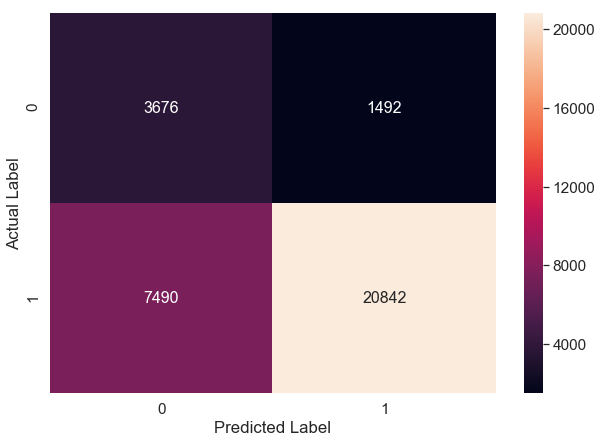

In [82]:
# train heat map

conf_mat_BOW_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

the maximum value of tpr*(1-fpr) 0.25 for threshold 0.501


Text(62.5, 0.5, 'Actual Label')

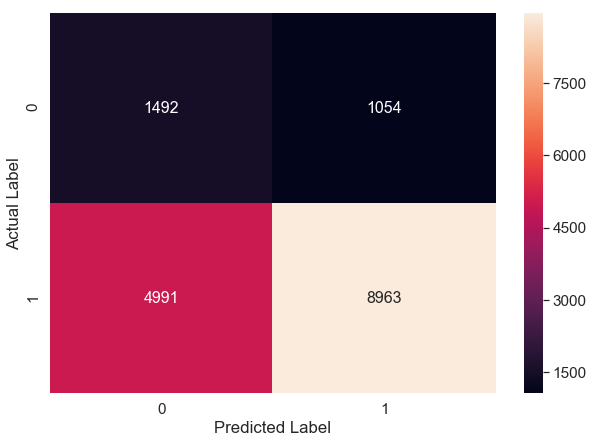

In [83]:
# test heat map 

conf_mat_BOW_test= pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_test, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

## <font color='RED'> SET 2</font>

###   Applying Random forest on <font color='red'> TFIDF</font>

In [89]:
from scipy.sparse import hstack


X_train_merge = hstack((cat_0_train, cat_1_train, subcat_0_train, subcat_1_train, state_0_train, state_1_train, proj_grade_0_train, proj_grade_1_train, teacher_prefix_0_train, teacher_prefix_1_train, price_data_train, quant_train, prev_no_projects_train,title_cnt_train,essay_cnt_train, essay_pos_train, essay_neg_train, essay_neu_train, essay_compound_train, title_tfidf_train, essay_tfidf_train)).tocsr()
X_test_merge = hstack((cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, state_0_test, state_1_test, proj_grade_0_test, proj_grade_1_test, teacher_prefix_0_test, teacher_prefix_1_test, price_data_test, quant_test, prev_no_projects_test,  essay_cnt_test,title_cnt_test,essay_pos_test, essay_neg_test, essay_neu_test, essay_compund_test, title_tfidf_test, essay_tfidf_test)).tocsr()


#### Best hyper parameter using the ROC/AUC higest value and K-fold cross validation.


In [90]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

rf = RandomForestClassifier()

parameters = {'n_estimators':[1, 5, 10, 50, 100, 500], 'max_depth': [5, 10, 100, 500]}


clf = GridSearchCV(rf, parameters, cv= 5 , scoring='roc_auc')

clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']



### Heatmap for the hyperparameters 


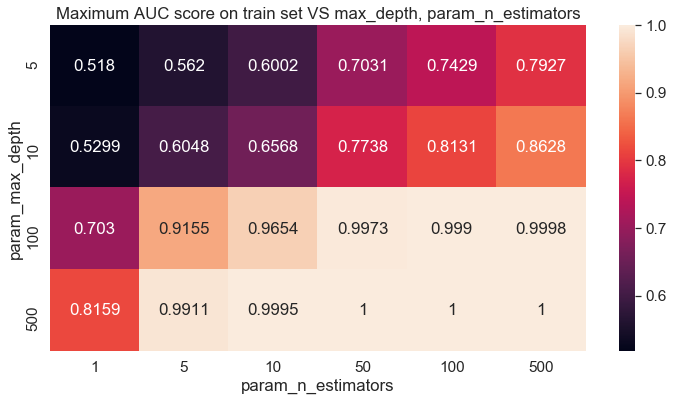

In [96]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

rf_gridsearch = pd.DataFrame(clf.cv_results_)

#Maximum AUC score on train set VS max_depth, min_samples_split
max_scores = rf_gridsearch.groupby(['param_max_depth',
                                    'param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.rcParams["figure.figsize"] = (12, 6)

title = 'Maximum AUC score on train set VS max_depth, param_n_estimators'

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

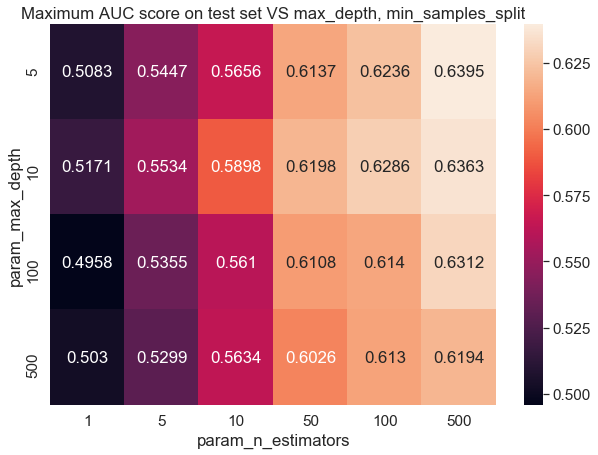

In [97]:
#Maximum AUC score on test set VS max_depth, min_samples_split

plt.rcParams["figure.figsize"] = (10, 7)


title = 'Maximum AUC score on test set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

### Best Train Model using best Hyper parameter

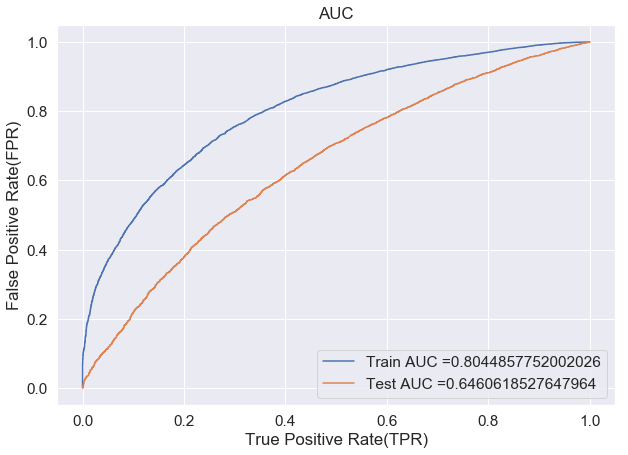

In [98]:
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth = 10, n_estimators= 100,class_weight='balanced')

clf = rf.fit(X_train_merge, Y_train)



y_train_pred = rf.predict_proba(X_train_merge)[:,1]    
y_test_pred = rf.predict_proba(X_test_merge)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

### Confusion Matrix


In [99]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.494
[[ 2584  2584]
 [ 3417 24915]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999984572938835 for threshold 0.504
[[1520 1026]
 [5324 8630]]


the maximum value of tpr*(1-fpr) 0.25 for threshold 0.494


Text(62.5, 0.5, 'Actual Label')

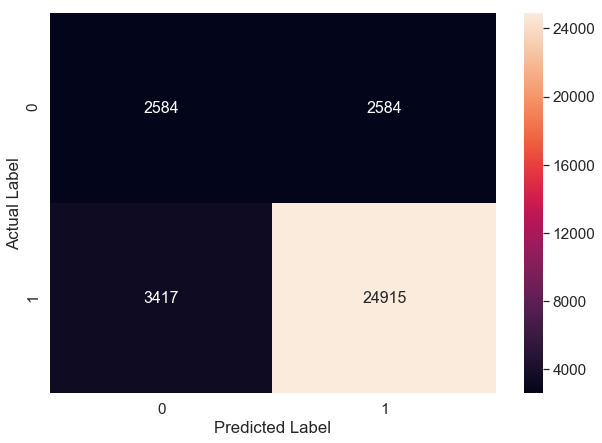

In [100]:
# heat map for train data
conf_matr_df_tfidf_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_tfidf_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

the maximum value of tpr*(1-fpr) 0.24999984572938835 for threshold 0.504


Text(62.5, 0.5, 'Actual Label')

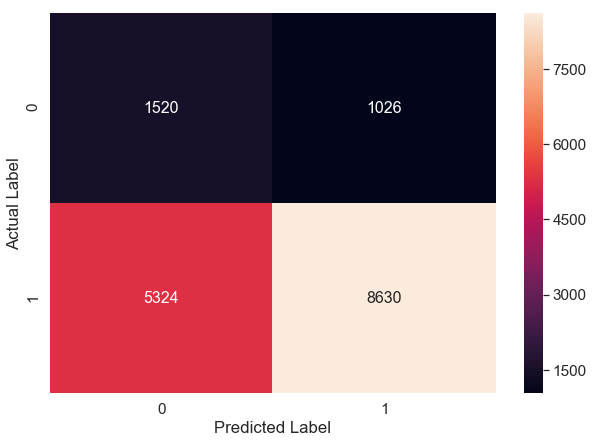

In [101]:
#Heat map for test data

conf_matr_df_tfidf_test = pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_tfidf_test, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

## <font color='RED'> SET 3</font>



###   Applying Random forest on <font color='red'> AVG W2V </font>


In [67]:
title_avg_w2v_train_arr=np.array(title_avg_w2v_train)
essay_avg_w2v_train_arr=np.array(essay_avg_w2v_train)
title_avg_w2v_test_arr=np.array(title_avg_w2v_test)
essay_avg_w2v_test_arr=np.array(essay_avg_w2v_test)

In [90]:
from scipy.sparse import hstack

X_train_merge = np.hstack((cat_0_train, cat_1_train, subcat_0_train, subcat_1_train, state_0_train, state_1_train, proj_grade_0_train, proj_grade_1_train, teacher_prefix_0_train, teacher_prefix_1_train, price_data_train, quant_train, prev_no_projects_train,title_cnt_train, essay_cnt_train, essay_pos_train, essay_neg_train, essay_neu_train, essay_compound_train, title_avg_w2v_train_arr, essay_avg_w2v_train_arr))
X_test_merge = np.hstack((cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, state_0_test, state_1_test, proj_grade_0_test, proj_grade_1_test, teacher_prefix_0_test, teacher_prefix_1_test, price_data_test, quant_test, prev_no_projects_test, title_cnt_test, essay_cnt_test, essay_pos_test, essay_neg_test, essay_neu_test, essay_compund_test, title_avg_w2v_test_arr, essay_avg_w2v_test_arr))

print("Final Data matrix")
print("="*100)
print(X_train_merge.shape, Y_train.shape)
print(X_test_merge.shape, Y_test.shape)
print("="*100)

Final Data matrix
(33500, 619) (33500,)
(16500, 619) (16500,)


#### Best hyper parameter using the ROC/AUC higest value and K-fold cross validation.


In [91]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

parameters = {'max_depth':[1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 100, 500]}


clf = GridSearchCV(rf, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
parm_max_depth = clf.cv_results_['param_max_depth']
param_min_samples_split = clf.cv_results_['param_min_samples_split']


### Heatmap for the hyperparameters 


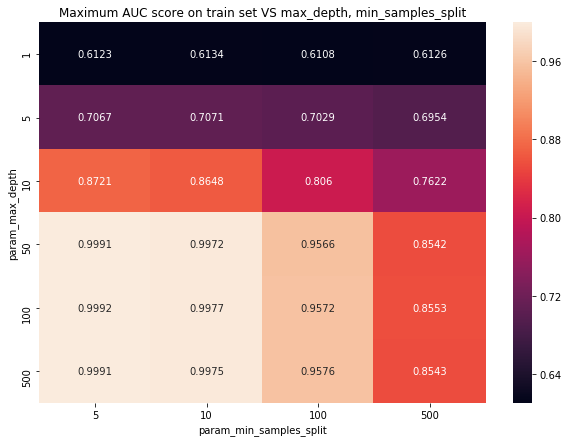

In [95]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

rf_gridsearch = pd.DataFrame(clf.cv_results_)

#Maximum AUC score on train set VS max_depth, min_samples_split
max_scores = rf_gridsearch.groupby(['param_max_depth',
                                    'param_min_samples_split']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.rcParams["figure.figsize"] = (10, 7)

title = 'Maximum AUC score on train set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

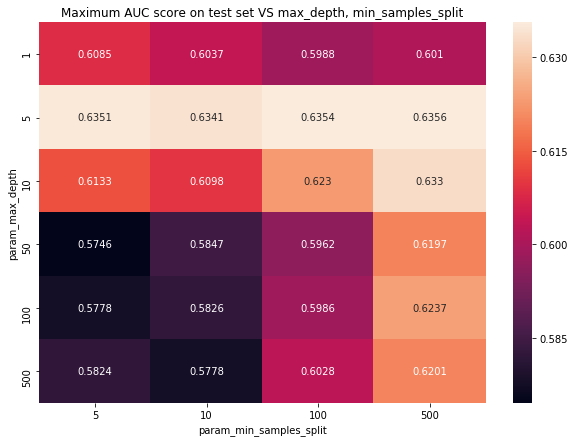

In [96]:
#Maximum AUC score on test set VS max_depth, min_samples_split

plt.rcParams["figure.figsize"] = (10, 7)


title = 'Maximum AUC score on test set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

### Best Train Model using best Hyper parameter

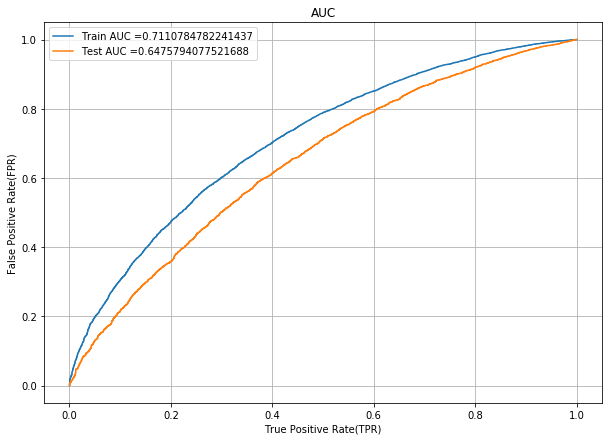

In [99]:
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth = 5, min_samples_split= 100,class_weight='balanced')

clf = rf.fit(X_train_merge, Y_train)

y_train_pred = rf.predict_proba(X_train_merge)[:,1]    
y_test_pred = rf.predict_proba(X_test_merge)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

### Confusion Matrix


In [103]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.481
[[ 2584  2584]
 [ 5997 22335]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.528
[[1780  766]
 [6941 7013]]


the maximum value of tpr*(1-fpr) 0.25 for threshold 0.481


Text(62.5, 0.5, 'Actual Label')

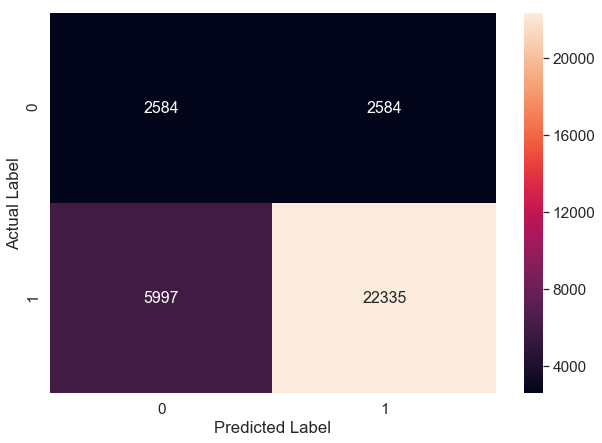

In [104]:
# heat map for train data
conf_matr_df_tfidf_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_tfidf_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

the maximum value of tpr*(1-fpr) 0.25 for threshold 0.528


Text(62.5, 0.5, 'Actual Label')

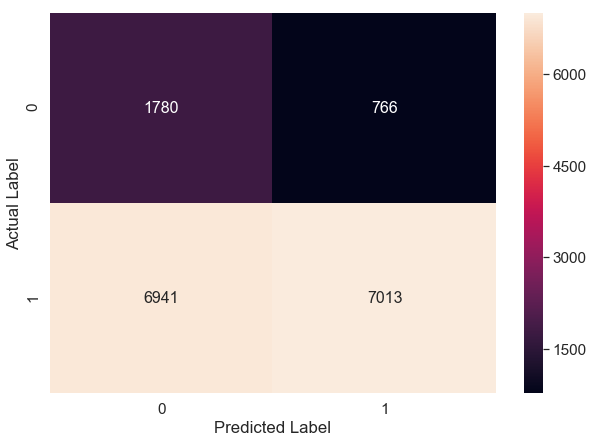

In [105]:
#Heat map for test data

conf_matr_df_tfidf_test = pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_tfidf_test, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

## <font color='RED'> SET 4</font>

###   Applying Random forest on <font color='red'> TFIDF W2V</font>

In [60]:
title_tfidf_w2v_train_arr=np.array(title_tfidf_w2v_train)
essay_tfidf_w2v_train_arr=np.array(essay_tfidf_w2v_train)
title_tfidf_w2v_test_arr=np.array(title_tfidf_w2v_test)
essay_tfidf_w2v_test_arr=np.array(essay_tfidf_w2v_test)

In [61]:
from scipy.sparse import hstack

X_train_merge = np.hstack((cat_0_train, cat_1_train, subcat_0_train, subcat_1_train, state_0_train, state_1_train, proj_grade_0_train, proj_grade_1_train, teacher_prefix_0_train, teacher_prefix_1_train, price_data_train, quant_train, prev_no_projects_train,title_cnt_train, essay_cnt_train, essay_pos_train, essay_neg_train, essay_neu_train, essay_compound_train, title_tfidf_w2v_train_arr, essay_tfidf_w2v_train_arr))
X_test_merge = np.hstack((cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, state_0_test, state_1_test, proj_grade_0_test, proj_grade_1_test, teacher_prefix_0_test, teacher_prefix_1_test, price_data_test, quant_test, prev_no_projects_test, title_cnt_test, essay_cnt_test, essay_pos_test, essay_neg_test, essay_neu_test, essay_compund_test, title_tfidf_w2v_test_arr, essay_tfidf_w2v_test_arr))

print("Final Data matrix")
print("="*100)
print(X_train_merge.shape, Y_train.shape)
print(X_test_merge.shape, Y_test.shape)
print("="*100)

Final Data matrix
(33500, 619) (33500,)
(16500, 619) (16500,)


#### Best hyper parameter using the ROC/AUC higest value and K-fold cross validation.


In [62]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

parameters = {'max_depth':[1, 5, 10, 50, 100, 500], 'min_samples_split': [5, 10, 100, 500]}


clf = GridSearchCV(rf, parameters, cv= 10, scoring='roc_auc')

clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
parm_max_depth = clf.cv_results_['param_max_depth']
param_min_samples_split = clf.cv_results_['param_min_samples_split']



### Heatmap for the hyperparameters 


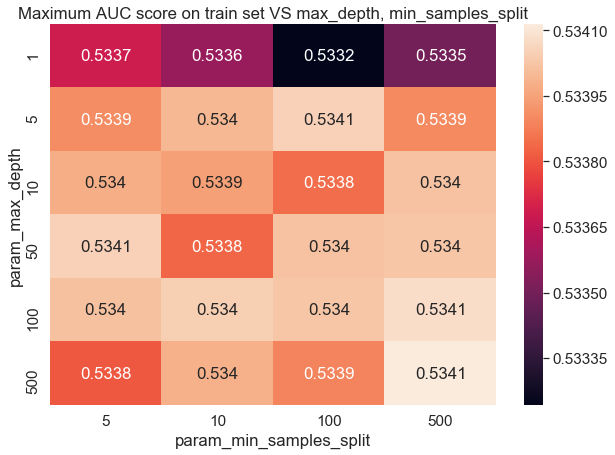

In [110]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

df_gridsearch = pd.DataFrame(clf.cv_results_)

#Maximum AUC score on train set VS max_depth, min_samples_split
max_scores = df_gridsearch.groupby(['param_max_depth',
                                    'param_min_samples_split']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.rcParams["figure.figsize"] = (10, 7)

title = 'Maximum AUC score on train set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

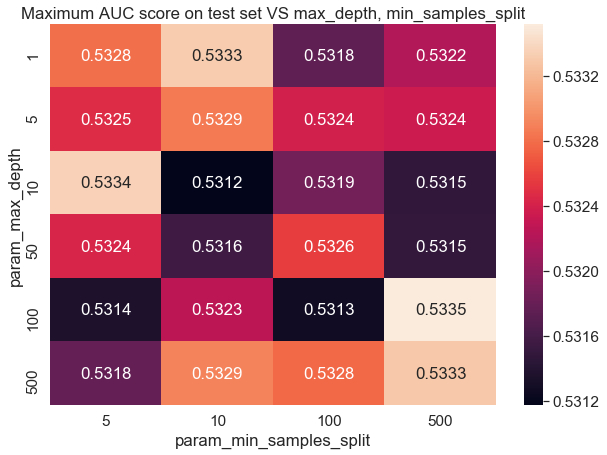

In [111]:
#Maximum AUC score on test set VS max_depth, min_samples_split

plt.rcParams["figure.figsize"] = (10, 7)


title = 'Maximum AUC score on test set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

### Best Train Model using best Hyper parameter

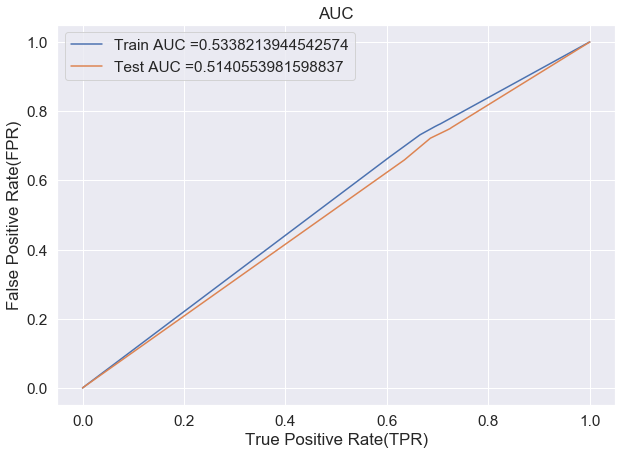

In [118]:
from sklearn.metrics import roc_curve, auc

rf = RandomForestClassifier(max_depth = 50, min_samples_split= 100,class_weight='balanced')

clf = rf.fit(X_train_merge, Y_train)

y_train_pred = rf.predict_proba(X_train_merge)[:,1]    
y_test_pred = rf.predict_proba(X_test_merge)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

### Confusion Matrix


In [119]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.23875612245876027 for threshold 0.526
[[ 2036  3132]
 [ 9394 18938]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.23185021681191761 for threshold 0.526
[[ 930 1616]
 [4754 9200]]


the maximum value of tpr*(1-fpr) 0.23875612245876027 for threshold 0.526


Text(62.5, 0.5, 'Actual Label')

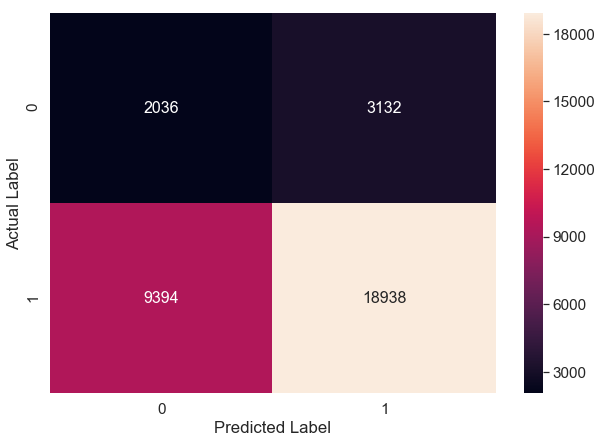

In [120]:
# heat map for train data
conf_matr_df_tfidf_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_tfidf_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

the maximum value of tpr*(1-fpr) 0.23185021681191761 for threshold 0.526


Text(62.5, 0.5, 'Actual Label')

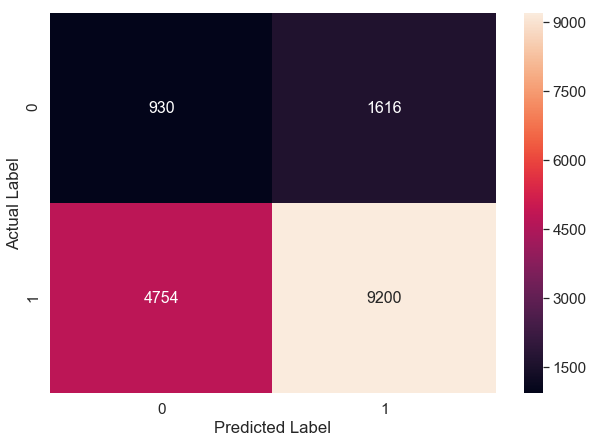

In [121]:
#Heat map for test data

conf_matr_df_tfidf_test = pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_matr_df_tfidf_test, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

## <font color='RED'> GBDT</font>

###   Applying GBDT on <font color='red'> BOW</font>

In [59]:
from scipy.sparse import hstack


X_train_merge = hstack((cat_0_train, cat_1_train, subcat_0_train, subcat_1_train, state_0_train, state_1_train, proj_grade_0_train, proj_grade_1_train, teacher_prefix_0_train, teacher_prefix_1_train, price_data_train, quant_train, prev_no_projects_train,title_cnt_train, essay_cnt_train, essay_pos_train, essay_neg_train, essay_neu_train, essay_compound_train, title_bow_train, essay_bow_train)).tocsr()
X_test_merge = hstack((cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, state_0_test, state_1_test, proj_grade_0_test, proj_grade_1_test, teacher_prefix_0_test, teacher_prefix_1_test, price_data_test, quant_test, prev_no_projects_test,title_cnt_test,essay_cnt_test, essay_pos_test, essay_neg_test, essay_neu_test, essay_compund_test, title_bow_test, essay_bow_test)).tocsr()

#### Best hyper parameter using the ROC/AUC higest value and K-fold cross validation.


In [60]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier()

param_distributions = {'n_estimators':[5, 10, 50, 100, 200, 500, 1000], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

clf = RandomizedSearchCV(gbdt, param_distributions, cv=3 , scoring='roc_auc' )


clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']


### Heatmap for the hyperparameters 


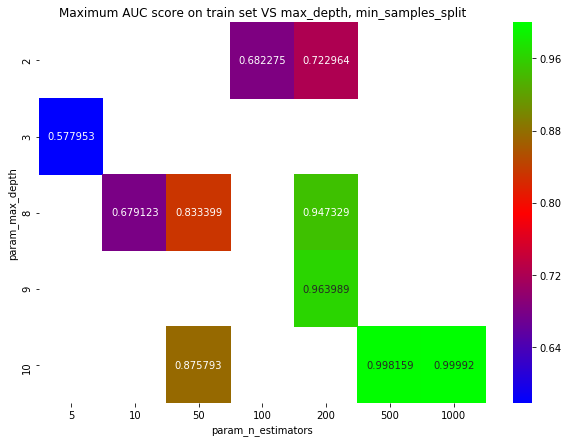

In [64]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

df_gridsearch = pd.DataFrame(clf.cv_results_)

#Maximum AUC score on train set VS max_depth, min_samples_split
max_scores = df_gridsearch.groupby(['param_max_depth',
                                    'param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.rcParams["figure.figsize"] = (10, 7)

title = 'Maximum AUC score on train set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='g',cmap="brg");
plt.title(title);

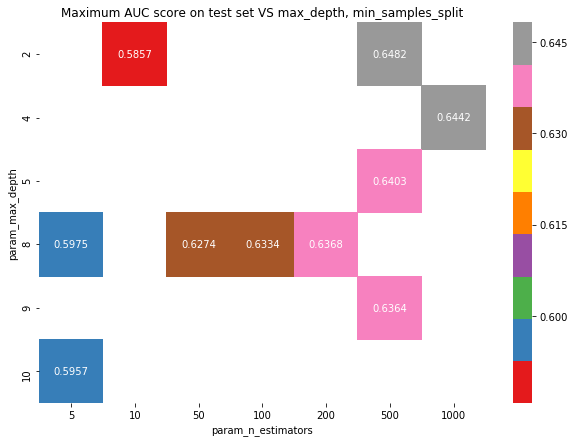

In [61]:
#Maximum AUC score on test set VS max_depth, min_samples_split

plt.rcParams["figure.figsize"] = (10, 7)


title = 'Maximum AUC score on test set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g',cmap="Set1");
plt.title(title);

### Best Train Model using best Hyper parameter

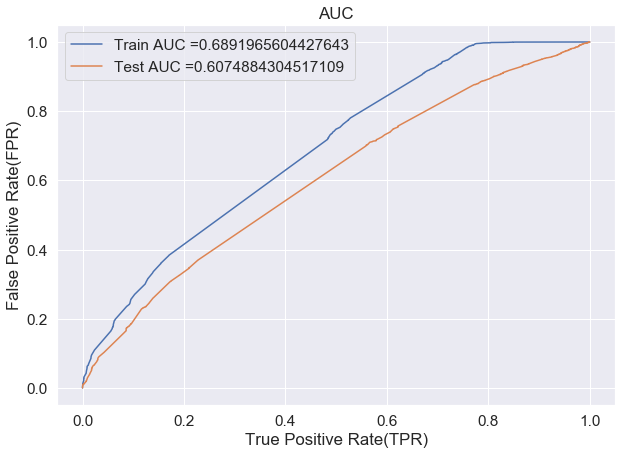

In [84]:
from sklearn.metrics import roc_curve, auc

gbdt = GradientBoostingClassifier(max_depth = 10, n_estimators= 10)

clf = gbdt.fit(X_train_merge, Y_train)

y_train_pred = gbdt.predict_proba(X_train_merge)[:,1]    
y_test_pred = gbdt.predict_proba(X_test_merge)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

### Confusion Matrix

In [85]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
        
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [86]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.3746415853006086 for threshold 0.845
[[ 2617  2551]
 [ 7371 20961]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.30927975557890186 for threshold 0.866
[[ 2304   242]
 [11390  2564]]


### Confusion Matrix -Heat map - Train


the maximum value of tpr*(1-fpr) 0.3746415853006086 for threshold 0.845


Text(62.5, 0.5, 'Actual Label')

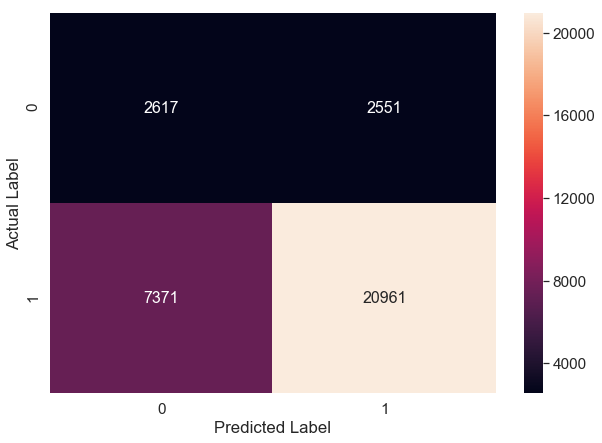

In [87]:
conf_mat_BOW_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

### Confusion Matrix -Heat map - Test


the maximum value of tpr*(1-fpr) 0.2467564603904034 for threshold 0.868


Text(62.5, 0.5, 'Actual Label')

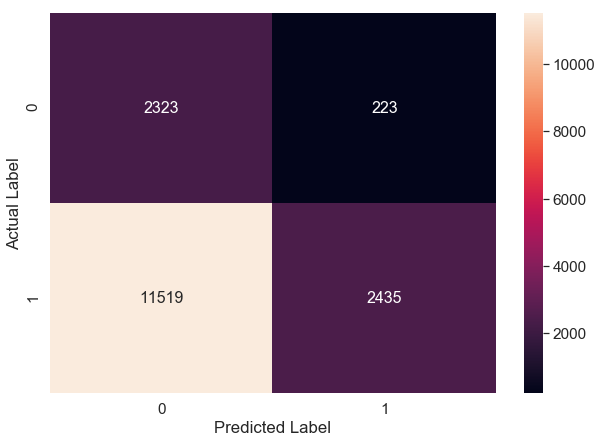

In [88]:
conf_mat_BOW_test= pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_test, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

###   Applying GBDT on <font color='red'> TFIDF</font>

In [58]:
from scipy.sparse import hstack


X_train_merge = hstack((cat_0_train, cat_1_train, subcat_0_train, subcat_1_train, state_0_train, state_1_train, proj_grade_0_train, proj_grade_1_train, teacher_prefix_0_train, teacher_prefix_1_train, price_data_train, quant_train, prev_no_projects_train,title_cnt_train,essay_cnt_train, essay_pos_train, essay_neg_train, essay_neu_train, essay_compound_train, title_tfidf_train, essay_tfidf_train)).tocsr()
X_test_merge = hstack((cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, state_0_test, state_1_test, proj_grade_0_test, proj_grade_1_test, teacher_prefix_0_test, teacher_prefix_1_test, price_data_test, quant_test, prev_no_projects_test,  essay_cnt_test,title_cnt_test,essay_pos_test, essay_neg_test, essay_neu_test, essay_compund_test, title_tfidf_test, essay_tfidf_test)).tocsr()


#### Best hyper parameter using the ROC/AUC higest value and K-fold cross validation.


In [59]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier()

param_distributions = {'n_estimators':[1, 5, 10, 50, 100, 500], 'max_depth': [5, 10, 100, 500]}

clf = RandomizedSearchCV(gbdt, param_distributions, cv=3 , scoring='roc_auc' )


clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

### Heatmap for the hyperparameters 


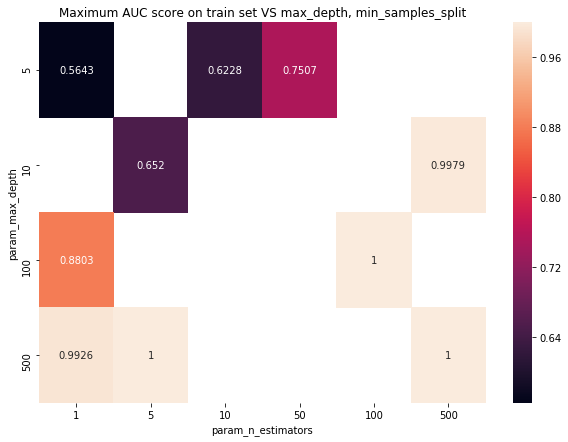

In [61]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

df_gridsearch = pd.DataFrame(clf.cv_results_)

#Maximum AUC score on train set VS max_depth, min_samples_split
max_scores = df_gridsearch.groupby(['param_max_depth',
                                    'param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.rcParams["figure.figsize"] = (10, 7)

title = 'Maximum AUC score on train set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

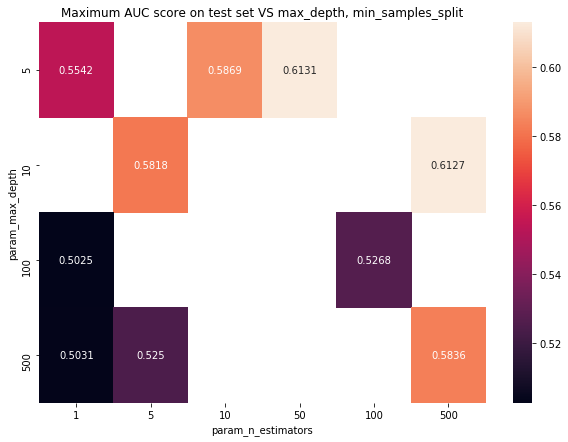

In [62]:
#Maximum AUC score on test set VS max_depth, min_samples_split

plt.rcParams["figure.figsize"] = (10, 7)


title = 'Maximum AUC score on test set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

### Best Train Model using best Hyper parameter

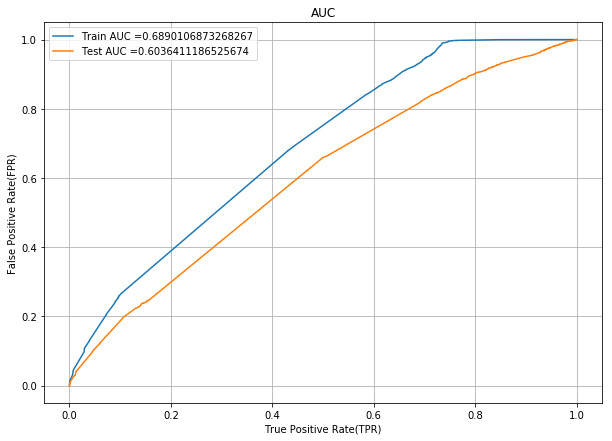

In [64]:
from sklearn.metrics import roc_curve, auc

gbdt = GradientBoostingClassifier(max_depth = 10, n_estimators= 10)

clf = gbdt.fit(X_train_merge, Y_train)

y_train_pred = gbdt.predict_proba(X_train_merge)[:,1]    
y_test_pred = gbdt.predict_proba(X_test_merge)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

### Confusion Matrix


In [67]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.38653835940849957 for threshold 0.85
[[ 2934  2234]
 [ 9042 19290]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.33038031142838203 for threshold 0.864
[[ 2177   369]
 [10637  3317]]


### Confusion Matrix -Heat map - Train


the maximum value of tpr*(1-fpr) 0.38653835940849957 for threshold 0.85


Text(62.5, 0.5, 'Actual Label')

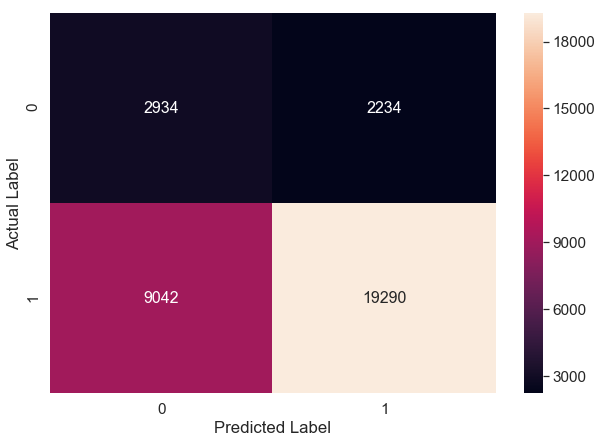

In [68]:
conf_mat_BOW_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

### Confusion Matrix -Heat map - Test


the maximum value of tpr*(1-fpr) 0.24999753167021388 for threshold 0.864


Text(62.5, 0.5, 'Actual Label')

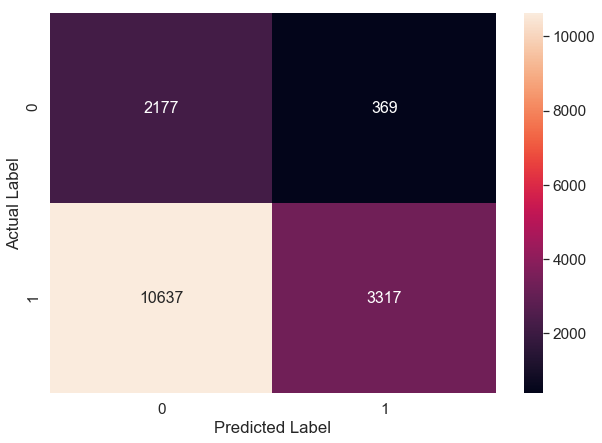

In [69]:
conf_mat_BOW_test= pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_test, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

###   Applying GBDT on <font color='red'> AVG W2V </font>


In [57]:
title_avg_w2v_train_arr=np.array(title_avg_w2v_train)
essay_avg_w2v_train_arr=np.array(essay_avg_w2v_train)
title_avg_w2v_test_arr=np.array(title_avg_w2v_test)
essay_avg_w2v_test_arr=np.array(essay_avg_w2v_test)

In [59]:
from scipy.sparse import hstack

X_train_merge = hstack((categories_one_hot_train, sub_cat_one_hot_train, school_state_one_hot_train, project_grade_cat_one_hot_train, teacher_prefix_cat_one_hot_train, price_data_train, quant_train, prev_no_projects_train,title_bow_train, essay_bow_train)).tocsr()
X_test_merge = hstack((categories_one_hot_test, sub_cat_one_hot_test, school_state_one_hot_test, project_grade_cat_one_hot_test, teacher_prefix_cat_one_hot_test, price_data_test, quant_test, prev_no_projects_test,title_bow_test, essay_bow_test)).tocsr()

NameError: name 'categories_one_hot_train' is not defined

#### Best hyper parameter using the ROC/AUC higest value and K-fold cross validation.


In [59]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier()

param_distributions = {'n_estimators':[1, 5, 10, 50, 100, 500], 'max_depth': [5, 10, 100, 500]}

clf = RandomizedSearchCV(gbdt, param_distributions, cv=3 , scoring='roc_auc' )


clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

### Heatmap for the hyperparameters 


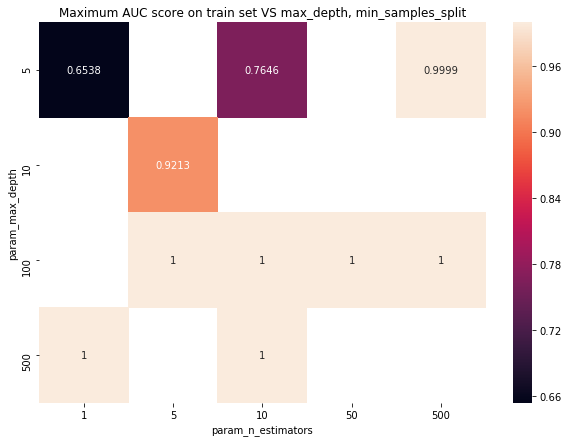

In [60]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

df_gridsearch = pd.DataFrame(clf.cv_results_)

#Maximum AUC score on train set VS max_depth, min_samples_split
max_scores = df_gridsearch.groupby(['param_max_depth',
                                    'param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.rcParams["figure.figsize"] = (10, 7)

title = 'Maximum AUC score on train set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

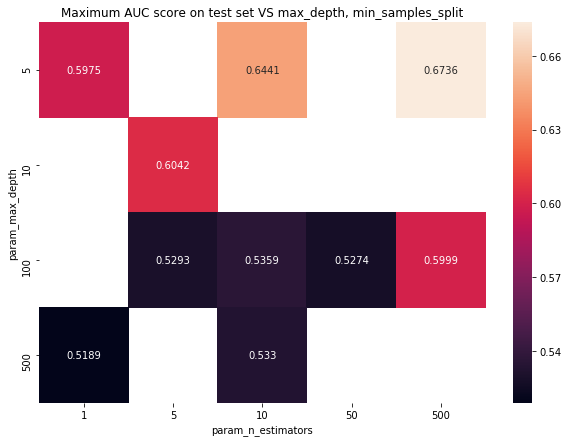

In [61]:
#Maximum AUC score on test set VS max_depth, min_samples_split

plt.rcParams["figure.figsize"] = (10, 7)


title = 'Maximum AUC score on test set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

### Best Train Model using best Hyper parameter

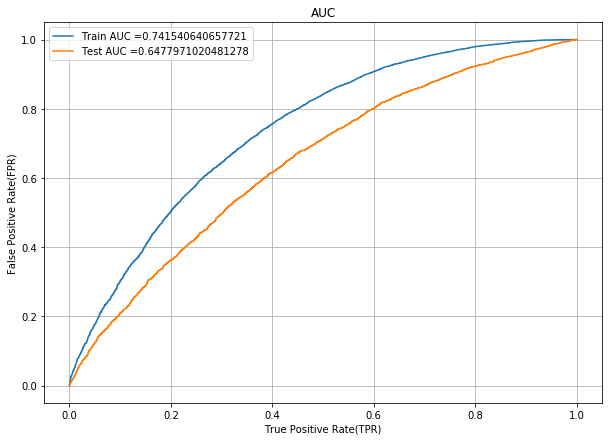

In [65]:
from sklearn.metrics import roc_curve, auc

gbdt = GradientBoostingClassifier(max_depth = 5, n_estimators= 10)

clf = gbdt.fit(X_train_merge, Y_train)

y_train_pred = gbdt.predict_proba(X_train_merge)[:,1]    
y_test_pred = gbdt.predict_proba(X_test_merge)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

### Confusion Matrix


In [68]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.45861257839924574 for threshold 0.841
[[ 3333  1835]
 [ 8185 20147]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.37121707605992127 for threshold 0.873
[[2158  388]
 [9846 4108]]


### Confusion Matrix -Heat map - Train


the maximum value of tpr*(1-fpr) 0.45861257839924574 for threshold 0.841


Text(62.5, 0.5, 'Actual Label')

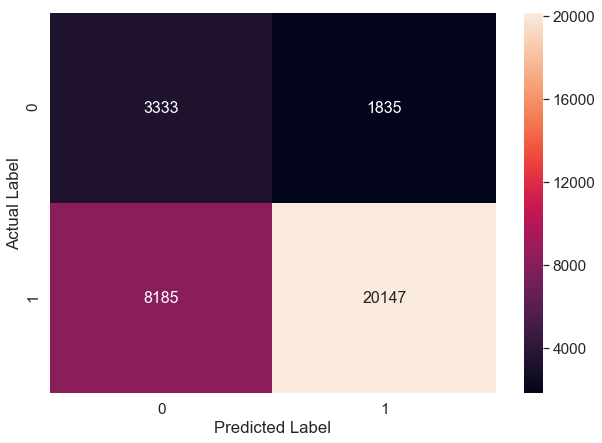

In [69]:
conf_mat_BOW_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

### Confusion Matrix -Heat map - Test


the maximum value of tpr*(1-fpr) 0.25 for threshold 0.868


Text(62.5, 0.5, 'Actual Label')

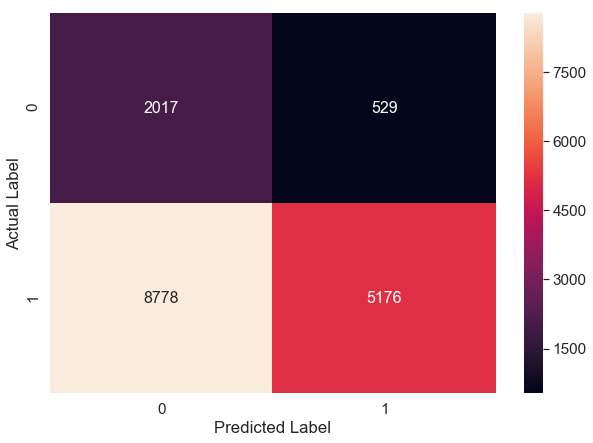

In [70]:
conf_mat_BOW_test= pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_test, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

###   Applying GBDT on <font color='red'> TFIDF W2V </font>


In [71]:
title_tfidf_w2v_train_arr=np.array(title_tfidf_w2v_train)
essay_tfidf_w2v_train_arr=np.array(essay_tfidf_w2v_train)
title_tfidf_w2v_test_arr=np.array(title_tfidf_w2v_test)
essay_tfidf_w2v_test_arr=np.array(essay_tfidf_w2v_test)


In [72]:
from scipy.sparse import hstack

X_train_merge = np.hstack((cat_0_train, cat_1_train, subcat_0_train, subcat_1_train, state_0_train, state_1_train, proj_grade_0_train, proj_grade_1_train, teacher_prefix_0_train, teacher_prefix_1_train, price_data_train, quant_train, prev_no_projects_train,title_cnt_train, essay_cnt_train, essay_pos_train, essay_neg_train, essay_neu_train, essay_compound_train, title_tfidf_w2v_train_arr, essay_tfidf_w2v_train_arr))
X_test_merge = np.hstack((cat_0_test, cat_1_test, subcat_0_test, subcat_1_test, state_0_test, state_1_test, proj_grade_0_test, proj_grade_1_test, teacher_prefix_0_test, teacher_prefix_1_test, price_data_test, quant_test, prev_no_projects_test, title_cnt_test, essay_cnt_test, essay_pos_test, essay_neg_test, essay_neu_test, essay_compund_test, title_tfidf_w2v_test_arr, essay_tfidf_w2v_test_arr))

print("Final Data matrix")
print("="*100)
print(X_train_merge.shape, Y_train.shape)
print(X_test_merge.shape, Y_test.shape)
print("="*100)

Final Data matrix
(33500, 619) (33500,)
(16500, 619) (16500,)


#### Best hyper parameter using the ROC/AUC higest value and K-fold cross validation.


In [73]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier()

param_distributions = {'n_estimators':[1, 5, 10, 50, 100, 500], 'max_depth': [5, 10, 100, 500]}

clf = RandomizedSearchCV(gbdt, param_distributions, cv=3 , scoring='roc_auc' )


clf.fit(X_train_merge,Y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

### Heatmap for the hyperparameters 


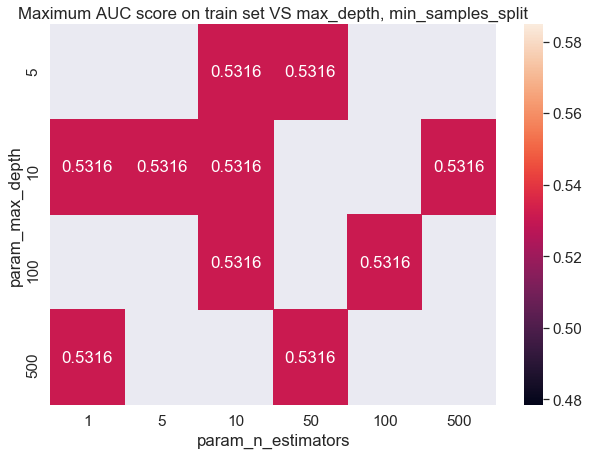

In [74]:
#https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9

df_gridsearch = pd.DataFrame(clf.cv_results_)

#Maximum AUC score on train set VS max_depth, min_samples_split
max_scores = df_gridsearch.groupby(['param_max_depth',
                                    'param_n_estimators']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.rcParams["figure.figsize"] = (10, 7)

title = 'Maximum AUC score on train set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');
plt.title(title);

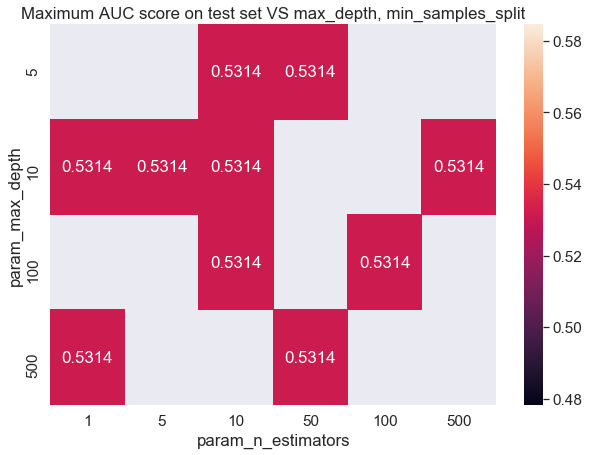

In [75]:
#Maximum AUC score on test set VS max_depth, min_samples_split

plt.rcParams["figure.figsize"] = (10, 7)


title = 'Maximum AUC score on test set VS max_depth, min_samples_split'

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

### Best Train Model using best Hyper parameter

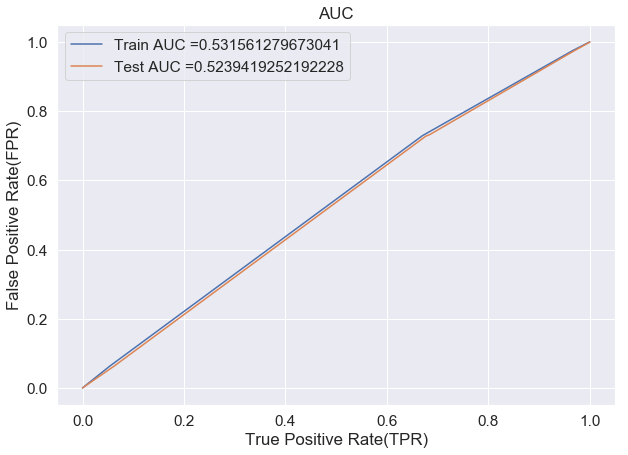

In [76]:
from sklearn.metrics import roc_curve, auc

gbdt = GradientBoostingClassifier(max_depth = 10, n_estimators= 10)

clf = gbdt.fit(X_train_merge, Y_train)

y_train_pred = gbdt.predict_proba(X_train_merge)[:,1]    
y_test_pred = gbdt.predict_proba(X_test_merge)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

### Confusion Matrix


In [77]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))
print("="*100)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24063701613639954 for threshold 0.852
[[ 1706  3462]
 [ 7679 20653]]
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2352462152323857 for threshold 0.852
[[  823  1723]
 [ 3799 10155]]


### Confusion Matrix -Heat map - Train


the maximum value of tpr*(1-fpr) 0.24063701613639954 for threshold 0.852


Text(62.5, 0.5, 'Actual Label')

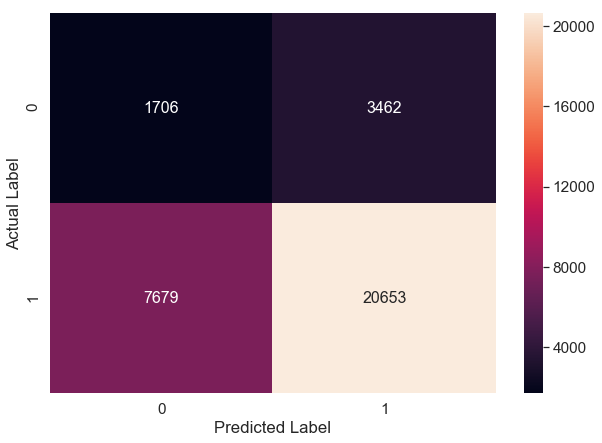

In [79]:
conf_mat_BOW_train = pd.DataFrame(confusion_matrix(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_train, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

### Confusion Matrix -Heat map - Train


the maximum value of tpr*(1-fpr) 0.21876020114419428 for threshold 0.852


Text(62.5, 0.5, 'Actual Label')

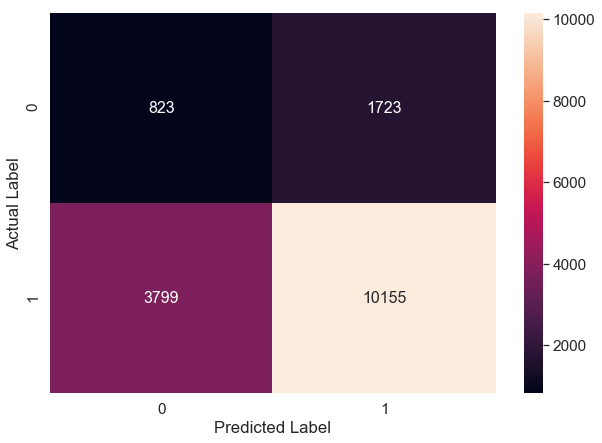

In [80]:
conf_mat_BOW_test= pd.DataFrame(confusion_matrix(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_BOW_test, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

## Conclusion

In [89]:
# Compare all your models using Prettytable library
#http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x_pretty_table = PrettyTable()
x_pretty_table.field_names = ["Model Type","Vectorizer","max_depth","n_estimators","Train-AUC","Test-AUC"]

x_pretty_table.add_row(["Random Forest","BOW",10,500,0.80,0.66])
x_pretty_table.add_row([ "Random Forest","TFIDF",10,100,0.80,0.65])
x_pretty_table.add_row([ "Random Forest","AVG W2V",5,100,0.71,0.65])
x_pretty_table.add_row([ "Random Forest","TFIDF W2V",50,100,0.53,0.51])
x_pretty_table.add_row(["GBDT","BOW",10,10,0.69,0.61])
x_pretty_table.add_row([ "GBDT","TFIDF",10,10,0.69,0.60])
x_pretty_table.add_row([ "GBDT","AVG W2V",5,10,0.74,0.65])
x_pretty_table.add_row([ "GBDT","TFIDF W2V",10,10,0.53,0.52])

print(x_pretty_table)

+---------------+------------+-----------+--------------+-----------+----------+
|   Model Type  | Vectorizer | max_depth | n_estimators | Train-AUC | Test-AUC |
+---------------+------------+-----------+--------------+-----------+----------+
| Random Forest |    BOW     |     10    |     500      |    0.8    |   0.66   |
| Random Forest |   TFIDF    |     10    |     100      |    0.8    |   0.65   |
| Random Forest |  AVG W2V   |     5     |     100      |    0.71   |   0.65   |
| Random Forest | TFIDF W2V  |     50    |     100      |    0.53   |   0.51   |
|      GBDT     |    BOW     |     10    |      10      |    0.69   |   0.61   |
|      GBDT     |   TFIDF    |     10    |      10      |    0.69   |   0.6    |
|      GBDT     |  AVG W2V   |     5     |      10      |    0.74   |   0.65   |
|      GBDT     | TFIDF W2V  |     10    |      10      |    0.53   |   0.52   |
+---------------+------------+-----------+--------------+-----------+----------+
